# Part 1: loads necessary modules and file paths 

In [1]:
%load_ext autoreload 
%autoreload 2
from typing import Tuple
import pandas as pd  # enables working with dataframes
import matplotlib.pyplot as plt  # a standard plotting package for python
import seaborn as sns  # extra tools for plotting (such as violin plots)
import numpy as np  # common mathematical functions
from pathlib import Path  # used for common file system operations
import networkx as nx  # package for plotting networks
from tqdm.notebook import tqdm  # in case tqdm does not work do: pip install --upgrade jupyter ipywidgets
from scipy.stats import linregress  # linear regression used for calculating the growth rates
from scipy.optimize import curve_fit  # curve fitting function used for fitting the M matrix parameters based on labelling data
from scipy.linalg import expm  # matrix exponent function (used in the calculation of the labelling function)

#EO: I cannot get rid of this part
#EN: there is a way but I need to teach you how to use `virtualenv` so let's keep this for now
import sys
sys.path.append( '../src/' ) #enables importing util
from age_balance_analysis import biomass
from age_balance_analysis.symbolic import SymbolicAgeBalanceAnalysis

# set the specific style of the figures (white background with gridlines)
sns.set_style("whitegrid")

# define the paths to lysine exchange data files
DATA_PATH = Path("../data/lysine_vacule_knockouts")
METABOLIC_LABELLING_DATA_PATH = DATA_PATH / "2024-02-28_MS_metabolites_EO_1.tsv"

# Part 2: loads and plots raw lysine labelling data

experiment      condition strain       fraction pulse_type  temp_celsius  \
0           14  Y679 spike-in   Y679  total soluble   spike-in            30   
1           14  Y679 spike-in   Y679  total soluble   spike-in            30   
2           14  Y679 spike-in   Y679  total soluble   spike-in            30   
3           14  Y679 spike-in   Y679  total soluble   spike-in            30   
4           14  Y679 spike-in   Y679  total soluble   spike-in            30   
5           14  Y679 spike-in   Y679  total soluble   spike-in            30   
6           14  Y679 spike-in   Y679  total soluble   spike-in            30   
7           15  Y679 spike-in   Y679  total soluble   spike-in            30   
8           15  Y679 spike-in   Y679  total soluble   spike-in            30   
9           15  Y679 spike-in   Y679  total soluble   spike-in            30   
10          15  Y679 spike-in   Y679  total soluble   spike-in            30   
11          15  Y679 spike-in   Y679  total soluble   spike-in            30   
12          15  Y679 spike-in   Y679  total soluble   spike-in            30   
13          15  Y679 spike-in   Y679  total soluble   spike-in            30   
14          14  Y679 spike-in   Y679        protein   spike-in            30   
15          14  Y679 spike-in   Y679        protein   spike-in            30   
16          14  Y679 spike-in   Y679        protein   spike-in            30   
17          14  Y679 spike-in   Y679        protein   spike-in            30   
18          14  Y679 spike-in   Y679        protein   spike-in            30   
19          14  Y679 spike-in   Y679        protein   spike-in            30   
20          14  Y679 spike-in   Y679        protein   spike-in            30   
21          15  Y679 spike-in   Y679        protein   spike-in            30   
22          15  Y679 spike-in   Y679        protein   spike-in            30   
23          15  Y679 spike-in   Y679        protein   spike-in            30   
24          15  Y679 spike-in   Y679        protein   spike-in            30   
25          15  Y679 spike-in   Y679        protein   spike-in            30   
26          15  Y679 spike-in   Y679        protein   spike-in            30   
27          15  Y679 spike-in   Y679        protein   spike-in            30   

    time_min  replicate metabolite  labelling  growth_dilution  signal_H  \
0          5          1  Lys0;Lys8   0.376624         0.947574       NaN   
1         10          1  Lys0;Lys8   0.278205         0.802569       NaN   
2         20          1  Lys0;Lys8   0.198911         0.829352       NaN   
3         30          1  Lys0;Lys8   0.162844         0.735621       NaN   
4         45          1  Lys0;Lys8   0.134033         0.666159       NaN   
5         60          1  Lys0;Lys8   0.115560         0.600329       NaN   
6         90          1  Lys0;Lys8   0.095968         0.483850       NaN   
7          5          2  Lys0;Lys8   0.404910         0.910355       NaN   
8         10          2  Lys0;Lys8   0.302344         0.722478       NaN   
9         20          2  Lys0;Lys8   0.216251         0.675072       NaN   
10        30          2  Lys0;Lys8   0.180187         0.644068       NaN   
11        45          2  Lys0;Lys8   0.149566         0.609100       NaN   
12        60          2  Lys0;Lys8   0.130497         0.518030       NaN   
13        90          2  Lys0;Lys8   0.109510         0.414789       NaN   
14         5          1  Lys0;Lys8   0.959102         0.947574       NaN   
15        10          1  Lys0;Lys8   0.932389         0.802569       NaN   
16        20          1  Lys0;Lys8   0.880022         0.829352       NaN   
17        30          1  Lys0;Lys8   0.827633         0.735621       NaN   
18        45          1  Lys0;Lys8   0.755364         0.666159       NaN   
19        60          1  Lys0;Lys8   0.688172         0.600329       NaN   
20        90          1  Lys0;Lys8   0.577018         0.483850       NaN   
21         

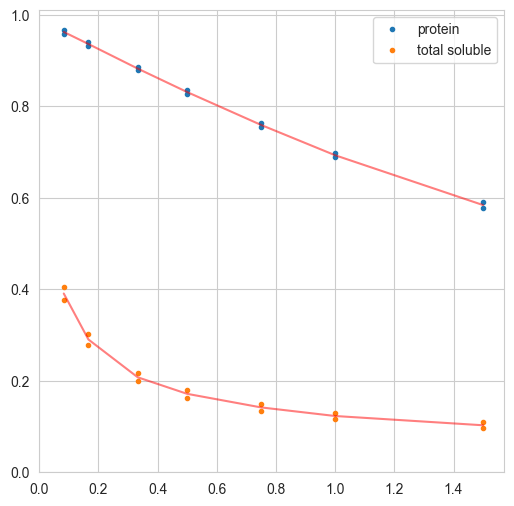

In [2]:
#EO:first tim point for lysine labelling has to be set to 1

# read the TAB-delimited lysine exchange data into a dataframe
labelling_df = pd.read_csv(METABOLIC_LABELLING_DATA_PATH, delimiter="\t")

# display the imported dataset 
display(labelling_df)

# convert time points form minutes to hours
labelling_df["time_h"] = labelling_df.time_min / 60.0

# create the figure canvas and axes for plotting
fig, ax = plt.subplots(1, 1, figsize=(6, 6), dpi=100)

# iterates over labelling data in different fractions
for fract, group_df in labelling_df.groupby("fraction"):
    
    # calculate the mean over replicates
    ax.plot(group_df.time_h, group_df.labelling, ".", label=fract)
    mean_values = group_df.groupby("time_h").mean("labelling")
    ax.plot(mean_values.index, mean_values.labelling, "r-", alpha=0.5, label=None)

# add a figure legend
ax.legend()

# set the x and y axes limits
ax.set_ylim(0, 1.01)
ax.set_xlim(0, None)

# save the plot to the file system
plt.savefig("raw_lysine_labelling.pdf", format="pdf", bbox_inches="tight")

In [3]:
# display raw lysine labelling data for fitting
labelling_df.loc[labelling_df.fraction == "total soluble", ["experiment", "strain", "pulse_type", "temp_celsius", "time_min", "replicate"]]

experiment strain pulse_type  temp_celsius  time_min  replicate
0           14   Y679   spike-in            30         5          1
1           14   Y679   spike-in            30        10          1
2           14   Y679   spike-in            30        20          1
3           14   Y679   spike-in            30        30          1
4           14   Y679   spike-in            30        45          1
5           14   Y679   spike-in            30        60          1
6           14   Y679   spike-in            30        90          1
7           15   Y679   spike-in            30         5          2
8           15   Y679   spike-in            30        10          2
9           15   Y679   spike-in            30        20          2
10          15   Y679   spike-in            30        30          2
11          15   Y679   spike-in            30        45          2
12          15   Y679   spike-in            30        60          2
13          15   Y679   spike-in            30        90          2

# Part 3: defines and parametrises a KSM based on experimental lysine labelling

convert the parameters to a $M$ matrix for a model with 3 states:
- $\rightarrow S_0$
- $\rightarrow  S_1$
- $S_0 \rightarrow S_2$
- $S_1 \rightarrow S_2$

where the measured labelling is only for $S_2$.

In this part, we fit the $M$ matrix with the unknown fractional transfer coefficients as free parameters, see Appendix 4.7 for the examples of $M$ matrix construction. 

In [4]:
lysine_aba = SymbolicAgeBalanceAnalysis(n_states=2, n_params=3)

lysine_aba.set_param_bounds(0, 0, 100)
lysine_aba.set_param_bounds(1, 0, 100)
lysine_aba.set_param_bounds(2, 0, 100)

p_0, p_1, p_2 = lysine_aba.get_params()
lysine_aba.set_coeff(0, 0, -p_0)
lysine_aba.set_coeff(1, 0, p_1)
lysine_aba.set_coeff(1, 1, -p_1 - p_2)

In [5]:
display(lysine_aba.get_contributed_turnover_matrix())

Matrix([
[-p_0,          0],
[ p_1, -p_1 - p_2]])

In [6]:
display(lysine_aba.display_bounds())

[(0.0 <= p_0, p_0 <= 100.0),
 (0.0 <= p_1, p_1 <= 100.0),
 (0.0 <= p_2, p_2 <= 100.0)]

In [7]:
# select the total soluble freaction only
total_soluble_df = labelling_df[labelling_df.fraction == "total soluble"]

# calculate the mean over all replicates
data_mean = total_soluble_df.groupby("time_h")[["labelling"]].mean().reset_index()

tdata = data_mean.time_h.values  # experimental data time series
ydata = data_mean.labelling.values  # experimental data labelling series
lysine_popt, lysine_pcov, rmse = lysine_aba.fit(tdata, ydata)
print("M = \n", lysine_aba.get_solution_M(lysine_popt).round(2))
print("\ns = \n", lysine_aba.get_solution_s(lysine_popt).round(2))
print(f"\nRMSE = {rmse:.2g}")

M = 
 [[ -0.76   0.  ]
 [  4.99 -19.26]]

s = 
 [0. 1.]

RMSE = -55


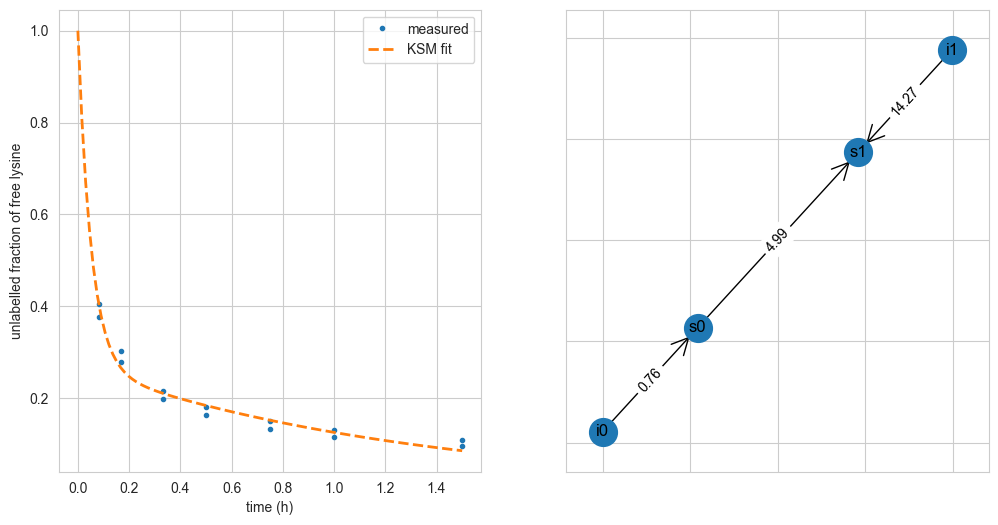

In [8]:
fig, axs = plt.subplots(1, 2, figsize=(12, 6), dpi=100)

# plot raw measured labelling data 
total_soluble_df.plot(x="time_h", y="labelling", linewidth=0, marker=".", label="measured", ax=axs[0])

# define the range of time points for plotting
t_range = np.linspace(start=0, stop=1.5, num=100)
f = lysine_aba.get_f_lambda(lysine_popt)
axs[0].plot(t_range, [f(t) for t in t_range], "--", linewidth=2, label="KSM fit")

axs[0].set_xlabel("time (h)")
axs[0].set_ylabel("unlabelled fraction of free lysine")
axs[0].legend()

lysine_aba.draw_transition_matrix(axs[1], lysine_popt)

# save the plot
fig.savefig("lysine_labelling_fit.pdf", format="pdf", bbox_inches="tight")

# Part 4: determines and plots growth rates for protein labelling experiments

In [9]:
# load the raw protein labelling data into a dataframe
LABELLING_DATA_PATH = DATA_PATH / "2024-03-07_MS_proteins_EO_8._exp9-12.tsv"
unfractionated_df = pd.read_csv(LABELLING_DATA_PATH, delimiter="\t")

# convert time points form minutes to hours
unfractionated_df["time_h"] = unfractionated_df.time_min / 60.0
display(unfractionated_df)

experiment                 condition strain           pulse_type  \
0               9  Y679 spike-in timecourse   Y679  spike-in timecourse   
1               9  Y679 spike-in timecourse   Y679  spike-in timecourse   
2               9  Y679 spike-in timecourse   Y679  spike-in timecourse   
3               9  Y679 spike-in timecourse   Y679  spike-in timecourse   
4               9  Y679 spike-in timecourse   Y679  spike-in timecourse   
...           ...                       ...    ...                  ...   
21895          12  Y679 spike-in timecourse   Y679  spike-in timecourse   
21896          12  Y679 spike-in timecourse   Y679  spike-in timecourse   
21897          12  Y679 spike-in timecourse   Y679  spike-in timecourse   
21898          12  Y679 spike-in timecourse   Y679  spike-in timecourse   
21899          12  Y679 spike-in timecourse   Y679  spike-in timecourse   

       temp_celsius  time_min  replicate         gene      gene_id channel  \
0                30       150          1  HSP82_HSC82  HSP82_HSC82      K1   
1                30       150          1  HSP82_HSC82  HSP82_HSC82      K2   
2                30        60          1  HSP82_HSC82  HSP82_HSC82      K1   
3                30        10          1  HSP82_HSC82  HSP82_HSC82      K1   
4                30        60          1  HSP82_HSC82  HSP82_HSC82      K2   
...             ...       ...        ...          ...          ...     ...   
21895            37        10          2        RPC82      YPR190C      K1   
21896            37       150          2         QCR2      YPR191W      K2   
21897            37       150          2         QCR2      YPR191W      K1   
21898            37        60          2         QCR2      YPR191W      K1   
21899            37        10          2         QCR2      YPR191W      K1   

       precursor_no  labelling  growth_dilution      signal_H      signal_L  \
0                49   0.449216         0.402903  4.599503e+07  3.650336e+07   
1                10   0.490947         0.402903  2.263859e+05  2.108314e+05   
2                47   0.737368         0.669397  2.256367e+07  6.019864e+07   
3                39   0.960900         0.933672  3.334023e+06  7.455006e+07   
4                 9   0.794243         0.669397  8.622818e+04  3.466145e+05   
...             ...        ...              ...           ...           ...   
21895             3   0.878921         0.943891  3.567421e+03  2.097543e+04   
21896             3   0.454116         0.419662  1.028366e+05  8.095659e+04   
21897            21   0.442080         0.419662  2.685823e+06  2.014189e+06   
21898            20   0.773786         0.693894  7.222972e+05  2.400950e+06   
21899            11   0.973871         0.943891  6.107658e+04  1.696071e+06   

         signal_tot    time_h  
0      8.249839e+07  2.500000  
1      4.372173e+05  2.500000  
2      8.276230e+07  1.000000  
3      7.788409e+07  0.166667  
4      4.328426e+05  1.000000  
...             ...       ...  
21895  2.454285e+04  0.166667  
21896  1.837931e+05  2.500000  
21897  4.700012e+06  2.500000  
21898  3.123247e+06  1.000000  
21899  1.757148e+06  0.166667  

[21900 rows x 17 columns]

condition strain           pulse_type  \
experiment                                                         
9           Y679 spike-in timecourse   Y679  spike-in timecourse   
10          Y679 spike-in timecourse   Y679  spike-in timecourse   
11          Y679 spike-in timecourse   Y679  spike-in timecourse   
12          Y679 spike-in timecourse   Y679  spike-in timecourse   

            temp_celsius  num_time_points  growth_rate  
experiment                                              
9                     30                3     0.362890  
10                    30                3     0.358581  
11                    37                3     0.339105  
12                    37                3     0.347735

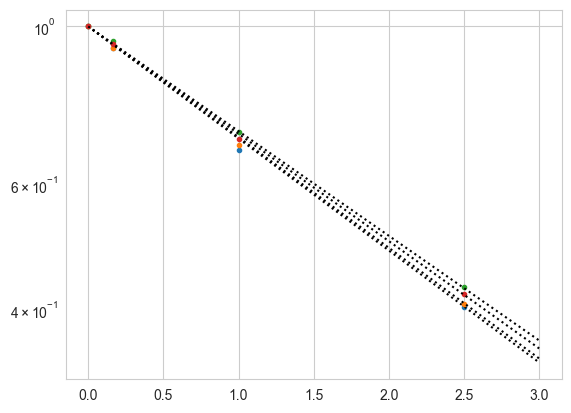

In [10]:
# format conditions and number of labelling time points in experiments 
metadata_df = unfractionated_df[
    ["experiment", "condition", "strain", "pulse_type", "temp_celsius", "time_h"]
].drop_duplicates()
metadata_df = metadata_df.groupby(["experiment", "condition", "strain", "pulse_type", "temp_celsius"]).count().time_h.reset_index().set_index("experiment")
metadata_df.rename(columns={"time_h": "num_time_points"}, inplace=True)

# select the experiments for fitting
EXPERIMENTS_FOR_FITTING = [9, 10, 11, 12]
metadata_df = metadata_df.loc[EXPERIMENTS_FOR_FITTING, :]

fig, ax = plt.subplots(1, 1)

# data structures for collecting and plotting growth rates
growth_rates = {}

# Use the Biomass data to calculate the growth rates
# use log-scaled growth_dilution data and linear regression to calculate the growth rates
for idx, group_df in unfractionated_df.groupby(["experiment"]):
    biomass_df = group_df.groupby(["time_h"]).growth_dilution.mean().reset_index()
    tdata = [0.0] + biomass_df.time_h.values.tolist()
    bdata = [0.0] + np.log(biomass_df.growth_dilution.values).tolist()
    
    linreg_result = linregress(tdata, bdata)
    growth_rates[idx] = -linreg_result.slope
    ax.plot(tdata, np.exp(bdata), ".", label=f"Exp_{idx[0]}, $\\beta$ = {growth_rates[idx]:.3g}, [1/h]")
    ax.plot([0, 3], [1, np.exp(-growth_rates[idx] * 3)], 'k:')

ax.set_yscale("log")  #growth dilution in log-ascale for plotting
plt.savefig("growth_rate_biomass_fitting.pdf", format="pdf", bbox_inches="tight")

metadata_df = metadata_df.join(pd.Series(growth_rates, name="growth_rate"),
                               on="experiment")  #appends calculated growth rates
display(metadata_df)

# Part 5: parameterize protein labelling KSM

function for fitting protein pool based on the metabolomics result, including 4 states:
- $\rightarrow S_0$
- $\rightarrow  S_1$
- $S_0 \rightarrow S_2$
- $S_1 \rightarrow S_2$
- $S_2 \rightarrow S_3$

where the parameters are all taken from the previous fit to the free lysine labelling (Part 3), and
the only fitted parameter is the fractional transfer coeffitients from $S_2$ to $S_3$.
The measured labelling is assumed to represent $S_3$ only.

(see Apendix 4.7 for the examples of $M$ matrix construction)


In [11]:
protein_aba_s4p3 = SymbolicAgeBalanceAnalysis(n_states=4, n_params=3)

p_0, p_1, p_2 = protein_aba_s4p3.get_params()

protein_aba_s4p3.set_param_bounds(0, 0, 1)
protein_aba_s4p3.set_param_bounds(1, 1, 100)
protein_aba_s4p3.set_param_bounds(2, 0, 1)

protein_aba_s4p3.set_coeff(0, 0, -lysine_popt[0])
protein_aba_s4p3.set_coeff(1, 0, lysine_popt[1])
protein_aba_s4p3.set_coeff(1, 1, -lysine_popt[1] - lysine_popt[2])
protein_aba_s4p3.set_coeff(2, 1, p_0)
protein_aba_s4p3.set_coeff(2, 2, -p_0)
protein_aba_s4p3.set_coeff(3, 1, p_1)
protein_aba_s4p3.set_coeff(3, 3, -p_1)
protein_aba_s4p3.set_observed_pool_weight(2, p_2)
protein_aba_s4p3.set_observed_pool_weight(3, 1 - p_2)
print("bounds: ", protein_aba_s4p3.display_bounds())
display("M = ", protein_aba_s4p3.get_contributed_turnover_matrix())

bounds:  [(0.0 <= p_0, p_0 <= 1.0), (1.0 <= p_1, p_1 <= 100.0), (0.0 <= p_2, p_2 <= 1.0)]


'M = '

Matrix([
[-0.764207776253121,                 0,    0,    0],
[   4.9940789775159, -19.2624833466398,    0,    0],
[                 0,               p_0, -p_0,    0],
[                 0,               p_1,    0, -p_1]])

In [12]:
protein_aba_s3p1 = SymbolicAgeBalanceAnalysis(n_states=3, n_params=1)

p_0, = protein_aba_s3p1.get_params()

protein_aba_s3p1.set_param_bounds(0, 0, 100)

protein_aba_s3p1.set_coeff(0, 0, -lysine_popt[0])
protein_aba_s3p1.set_coeff(1, 0, lysine_popt[1])
protein_aba_s3p1.set_coeff(1, 1, -lysine_popt[1] - lysine_popt[2])
protein_aba_s3p1.set_coeff(2, 1, p_0)
protein_aba_s3p1.set_coeff(2, 2, -p_0)
print("bounds: ", protein_aba_s3p1.display_bounds())
display("M = ", protein_aba_s3p1.get_contributed_turnover_matrix())

bounds:  [(0.0 <= p_0, p_0 <= 100.0)]


'M = '

Matrix([
[-0.764207776253121,                 0,    0],
[   4.9940789775159, -19.2624833466398,    0],
[                 0,               p_0, -p_0]])

In [63]:
def plot_fits(exp, gene):
    filtered_df = unfractionated_df[
        (unfractionated_df.channel == "K1") &
        (unfractionated_df.precursor_no > 2)
    ]
    _df = filtered_df[filtered_df.experiment == exp].pivot(index="gene", columns="time_h", values="labelling")
    tdata = _df.columns.to_numpy()
    ydata = _df.loc[gene, :].to_numpy()
    
    fig, ax = plt.subplots(1, 1, figsize=(6, 6), dpi=100)
    ax.set_title(f"Exp = {exp}, gene = {gene}")
    filtered_df[(filtered_df.experiment == exp) & (filtered_df.gene == gene)].plot(x="time_h", y="labelling", linewidth=0, marker="v", markersize=8, label="measured", ax=ax, zorder=2)
    lysine_aba.draw_trajectory(ax, lysine_popt, label="free lysine pool", linewidth=1)
    for aba in [protein_aba_s3p1, protein_aba_s4p3]:
        protein_popt, protein_pcov, protein_aic = aba.fit(tdata, ydata)
        age = aba.get_mean_age(protein_popt)
        lifespan = aba.get_mean_lifespan(protein_popt)
        print("-"*50)
        print(f"MODEL WITH {aba.n_states} states and {aba.n_params} parameters")
        print(f"ΔAIC = {protein_aic:.2f}, age = {age:.2f}, lifespan = {lifespan:.2f}")
        print("M_opt = \n", aba.get_solution_M(protein_popt).round(2))
        print("\ns_opt = \n", aba.get_solution_s(protein_popt).round(2))

        
        # plot raw measured labelling data 
        aba.draw_trajectory(ax, protein_popt, label=f"KSM {aba.n_params} parameters", linewidth=1, zorder=1)
    ax.legend()

--------------------------------------------------
MODEL WITH 3 states and 1 parameters
ΔAIC = -14.42, age = 2.83, lifespan = -inf
M_opt = 
 [[ -0.76   0.     0.  ]
 [  4.99 -19.26   0.  ]
 [  0.     0.41  -0.41]]

s_opt = 
 [0. 0. 1.]
--------------------------------------------------
MODEL WITH 4 states and 3 parameters
ΔAIC = -16.43, age = 3.22, lifespan = -1200959900632132.25
M_opt = 
 [[  -0.76    0.      0.      0.  ]
 [   4.99  -19.26    0.      0.  ]
 [   0.      0.3    -0.3     0.  ]
 [   0.    100.      0.   -100.  ]]

s_opt = 
 [0.   0.   0.86 0.14]


/home/eladn/git/age-balance-analysis/src/age_balance_analysis/symbolic.py:103: RuntimeWarning: divide by zero encountered in scalar divide
  return -s @ self._ones / s @ M @ self._ones
/home/eladn/git/age-balance-analysis/src/age_balance_analysis/symbolic.py:140: OptimizeWarning: Covariance of the parameters could not be estimated
  result = curve_fit(


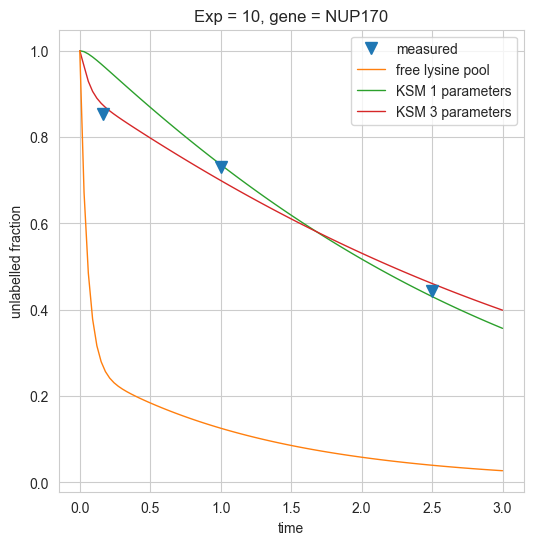

In [64]:
#plot_fits(exp = 10, gene = "MLP1")
plot_fits(exp = 10, gene = "NUP170")

In [14]:
# collect fitting results: fitted prametes, error, fit mse
result_list = []

# define data for fitting
# EN: it looks like you only chose one time point for the fitting, why?
filtered_df = unfractionated_df[
    (unfractionated_df.channel == "K1") &
    (unfractionated_df.precursor_no > 2)
]

for aba in [protein_aba_s3p1, protein_aba_s4p3]:
    print(f"MODEL WITH {aba.n_states} states and {aba.n_params} parameters")
    for experiment, row in metadata_df.iterrows():
        _df = filtered_df[filtered_df.experiment == experiment].pivot(
            index="gene", columns="time_h", values="labelling"
        ).dropna()
    
        for idx in tqdm(_df.index, desc=f"Exp_{experiment}"):
            tdata = _df.columns.to_numpy()
            ydata = _df.loc[idx, :].to_numpy()
            popt, pcov, aic = aba.fit(tdata, ydata)
            result_list.append([aba.n_states, aba.n_params, experiment, idx, popt, pcov, aic])
            

MODEL WITH 3 states and 1 parameters


Exp_9:   0%|          | 0/1362 [00:00<?, ?it/s]

Exp_10:   0%|          | 0/1362 [00:00<?, ?it/s]

Exp_11:   0%|          | 0/1318 [00:00<?, ?it/s]

Exp_12:   0%|          | 0/1318 [00:00<?, ?it/s]

MODEL WITH 4 states and 3 parameters


Exp_9:   0%|          | 0/1362 [00:00<?, ?it/s]

/home/eladn/git/age-balance-analysis/src/age_balance_analysis/symbolic.py:130: OptimizeWarning: Covariance of the parameters could not be estimated
  result = curve_fit(


Exp_10:   0%|          | 0/1362 [00:00<?, ?it/s]

/home/eladn/git/age-balance-analysis/src/age_balance_analysis/symbolic.py:130: OptimizeWarning: Covariance of the parameters could not be estimated
  result = curve_fit(


Exp_11:   0%|          | 0/1318 [00:00<?, ?it/s]

/home/eladn/git/age-balance-analysis/src/age_balance_analysis/symbolic.py:130: OptimizeWarning: Covariance of the parameters could not be estimated
  result = curve_fit(


Exp_12:   0%|          | 0/1318 [00:00<?, ?it/s]

/home/eladn/git/age-balance-analysis/src/age_balance_analysis/symbolic.py:130: OptimizeWarning: Covariance of the parameters could not be estimated
  result = curve_fit(


In [15]:
# display and save the fitting results
columns = ["n_states", "n_params", "experiment", "gene", "popt", "pcov", "delta_aic"]
result_df = pd.DataFrame(result_list, columns=columns)
result_df.to_csv('results_protein_KSM.csv', index=False)

Text(0, 0.5, 'model with 3 parameters')

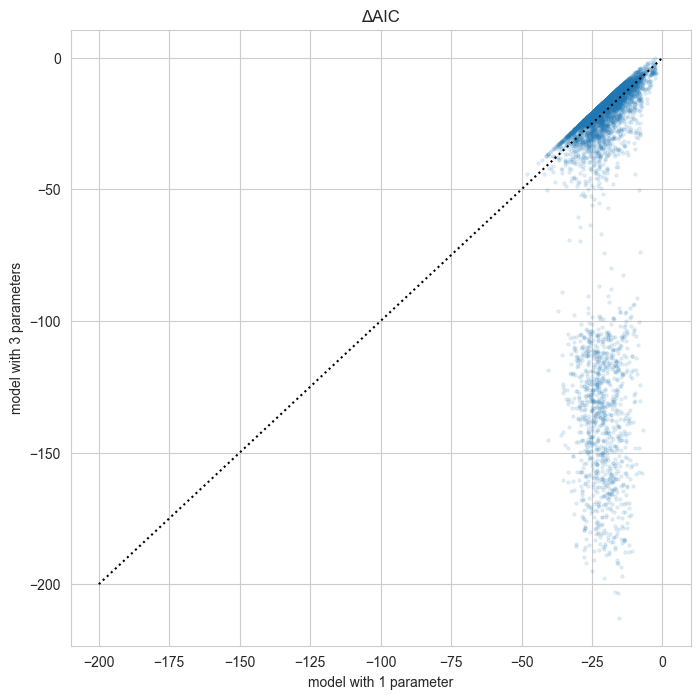

In [16]:
aic_df = result_df[["experiment", "gene", "n_params", "delta_aic"]].copy()
aic_df = aic_df.pivot(index=["experiment", "gene"], columns=["n_params"], values="delta_aic")
fig, ax = plt.subplots(1, 1, figsize=(8, 8), dpi=100)
aic_df.plot(kind="scatter", x=1, y=3, marker=".", alpha=0.1, ax=ax)
ax.plot([-200, 0], [-200, 0], "k:")
ax.set_title("ΔAIC")
ax.set_xlabel("model with 1 parameter")
ax.set_ylabel("model with 3 parameters")

--------------------------------------------------
MODEL WITH 3 states and 1 parameters
ΔAIC = -48.10, age = 3.80, lifespan = -inf
M_opt = 
 [[ -0.76   0.     0.  ]
 [  4.99 -19.26   0.  ]
 [  0.     0.29  -0.29]]

s_opt = 
 [0. 0. 1.]
--------------------------------------------------
MODEL WITH 4 states and 3 parameters
ΔAIC = -44.10, age = 3.80, lifespan = -inf
M_opt = 
 [[ -0.76   0.     0.     0.  ]
 [  4.99 -19.26   0.     0.  ]
 [  0.     0.29  -0.29   0.  ]
 [  0.     1.     0.    -1.  ]]

s_opt = 
 [0. 0. 1. 0.]


/home/eladn/git/age-balance-analysis/src/age_balance_analysis/symbolic.py:103: RuntimeWarning: divide by zero encountered in scalar divide
  return -s @ self._ones / s @ M @ self._ones
/home/eladn/git/age-balance-analysis/src/age_balance_analysis/symbolic.py:140: OptimizeWarning: Covariance of the parameters could not be estimated
  result = curve_fit(


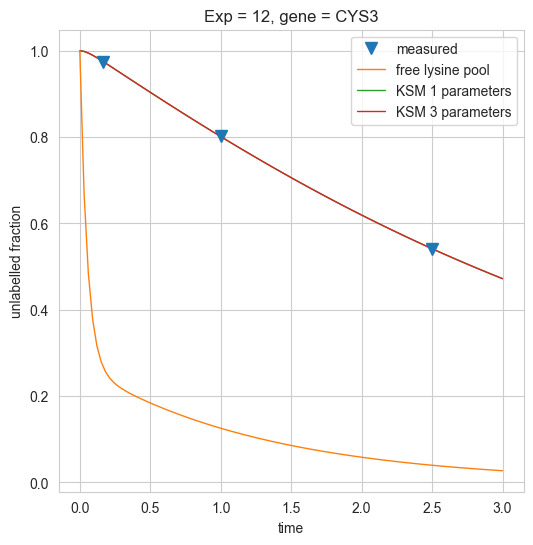

In [65]:
exp, gene = (aic_df[1] - aic_df[3]).sort_values().index[0]
plot_fits(exp = exp, gene = gene)

--------------------------------------------------
MODEL WITH 3 states and 1 parameters
ΔAIC = -15.28, age = 2.73, lifespan = -inf
M_opt = 
 [[ -0.76   0.     0.  ]
 [  4.99 -19.26   0.  ]
 [  0.     0.43  -0.43]]

s_opt = 
 [0. 0. 1.]
--------------------------------------------------
MODEL WITH 4 states and 3 parameters
ΔAIC = -212.74, age = 4.61, lifespan = 18014398509481984.00
M_opt = 
 [[ -0.76   0.     0.     0.  ]
 [  4.99 -19.26   0.     0.  ]
 [  0.     0.15  -0.15   0.  ]
 [  0.     2.1    0.    -2.1 ]]

s_opt = 
 [0.   0.   0.61 0.39]


/home/eladn/git/age-balance-analysis/src/age_balance_analysis/symbolic.py:103: RuntimeWarning: divide by zero encountered in scalar divide
  return -s @ self._ones / s @ M @ self._ones
/home/eladn/git/age-balance-analysis/src/age_balance_analysis/symbolic.py:140: OptimizeWarning: Covariance of the parameters could not be estimated
  result = curve_fit(


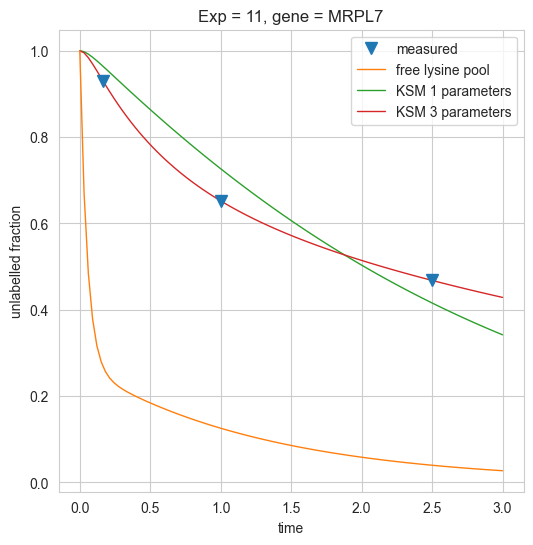

In [66]:
exp, gene = (aic_df[3] - aic_df[1]).sort_values().index[0]
plot_fits(exp = exp, gene = gene)

ValueError: Could not interpret value `p_0` for `y`. An entry with this name does not appear in `data`.

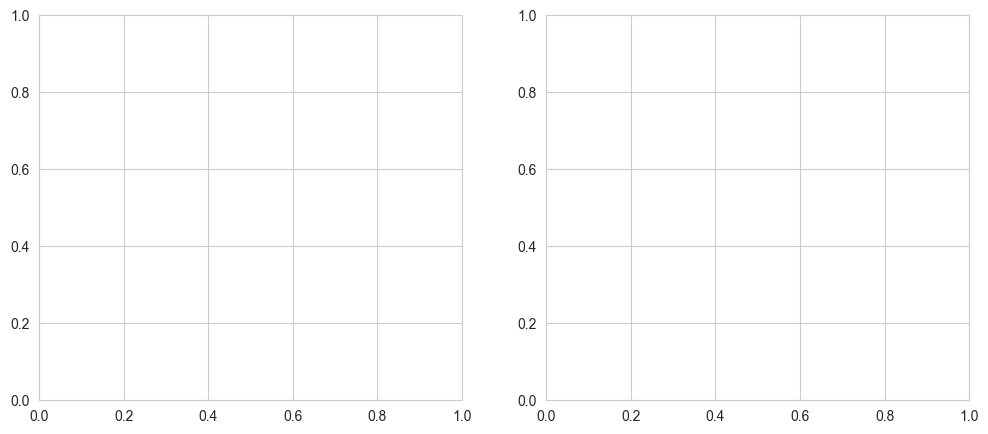

In [67]:
#EO: did not use it
#EO: need general formula to calculate average age and lifespan for the observed protein pools
fig, axs = plt.subplots(1, 2, figsize=(12, 5))
sns.violinplot(data=result_df, x="experiment", y="p_0", log_scale=True, ax=axs[0])
axs[0].set_ylim([0.1, 2])
for exp, group_df in result_df.groupby("experiment"):
    axs[1].hist(group_df.p_0, bins=np.logspace(-1, 2.1, 1000), density=True, cumulative=True, histtype="step", label=exp)
axs[1].legend()
axs[1].set_xscale("log")
axs[1].set_xlim([0.1, 2])

In [ ]:
#EO: did not use it
#EO: need general formula to calculate average age and lifespan for the observed protein pools
fig, ax = plt.subplots(1, 1, figsize=(8, 8), dpi=120)
pivot_df = result_df.pivot(index="gene", columns="experiment", values="p_0")
ax.plot(1.0/pivot_df[9], 1.0/pivot_df[11], '.', alpha=0.1)
ax.plot(1.0/pivot_df[10], 1.0/pivot_df[12], '.', alpha=0.1)
ax.set_xscale("log")
ax.set_yscale("log")
ax.plot([.1, 10], [.1, 10], "k--")
ax.set_xlim([0.5, 10])
ax.set_ylim([0.5, 10])
ax.set_xlabel("1/$p_0$ (at 30C)")
ax.set_ylabel("1/$p_0$ (at 37C)")

In [ ]:
#EO: makes sense to:
#EO: - add growth dilution curve considering the lysine input
#EO: - add protein labelling curve w/o lysine linput (as step-function)
#EO: - add to the legend the average age values with an without lysine input

param_table = result_df.set_index(["experiment", "gene", "n_params"]).popt

NameError: name 'param_table' is not defined

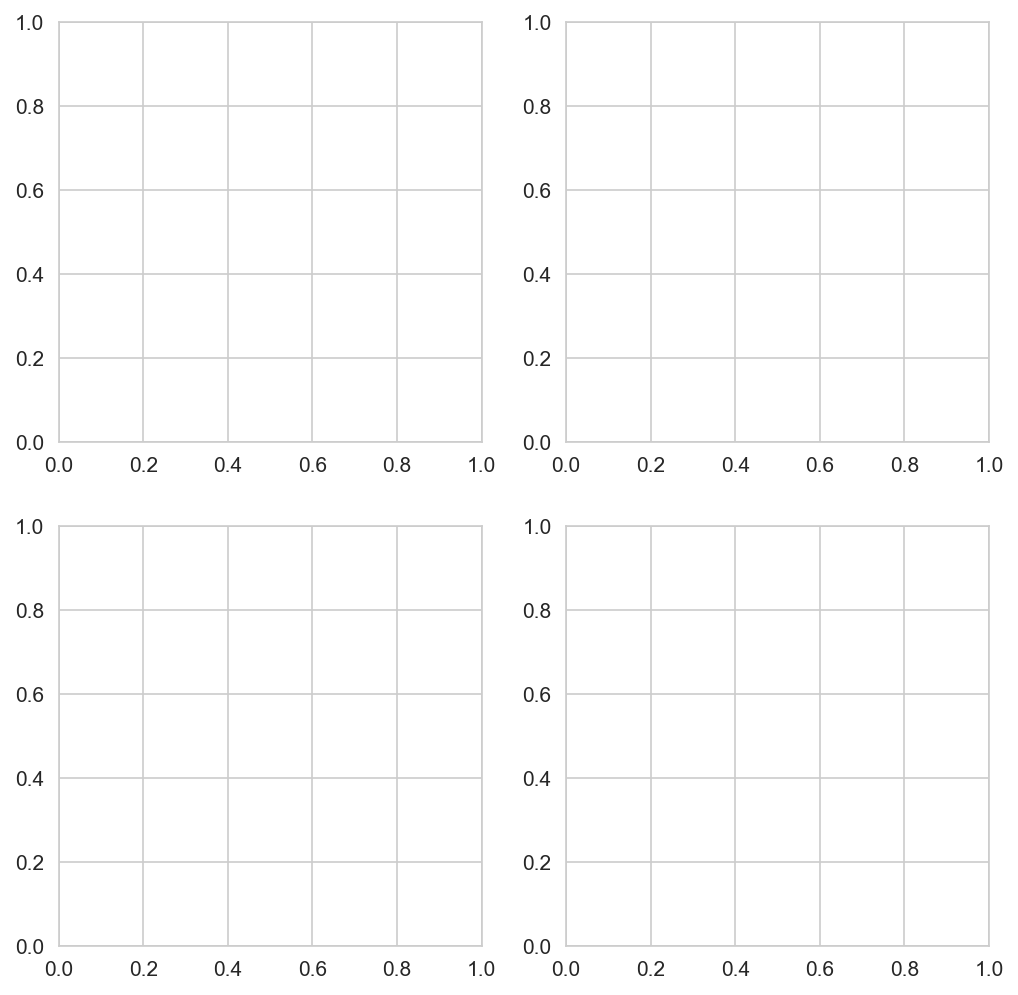

In [46]:

# here you can select two genes and two experiment numbers to show fiting results
exp_1 = 10
exp_2 = 11
gene_1 = "MLP1"
gene_2 = "NUP192"

fig, axs = plt.subplots(2, 2, figsize=(8, 8), dpi=150)

for i, exp in enumerate([exp_1, exp_2]):
    growth_rate = metadata_df.loc[exp, "growth_rate"]
    _df = filtered_df[filtered_df.experiment == exp].pivot(index="gene", columns="time_h", values="labelling")
    for j, gene in enumerate([gene_1, gene_2]):
        ax = axs[i, j]
        xdata = _df.columns.to_numpy()
        ydata = _df.loc[gene, :].to_numpy()

        t_range = np.linspace(start=0, stop=5, num=500)
        f_protein = protein_aba_s4p3.get_f_lambda(param_table[(exp, gene, 3)])
    
        ax.scatter(xdata, ydata, color="coral", s=12, label=f"Exp_{exp}, {gene}")
        ax.plot(t_range, [np.exp(-growth_rate * t) for t in t_range], '--', color="grey", linewidth=1,
                label="growth dilution")
        ax.plot(t_range, [f_protein(t) for t in t_range], '-', color="green", linewidth=1,
                label="KSM fit")
        ax.set_ylim(0, 1.1)
        ax.set_ylabel("unlabeled fraction")
        ax.set_xlabel("time [units of 1/$\\mu$]")
        ax.legend()
fig.tight_layout()

#EO: can one color observed pools and include pool contributions?

fig, axs = plt.subplots(2, 2, figsize=(8, 8), dpi=150)
for i, exp in enumerate([exp_1, exp_2]):
    for j, gene in enumerate([gene_1, gene_2]):
        ax = axs[i, j]
        s = protein_aba_s4p3.draw_transition_matrix(ax, param_table[(exp, gene, 3)])
fig.tight_layout()

Probability Distribution Functions (p.d.f):
- age : $-\mathbf{s}^\top \mathbf{M} e^{\mathbf{M}t} \mathbf{1_n} ~\big/~ \mathbf{s}^\top \mathbf{1_n}$
- transit-time: $-\mathbf{s}^\top \mathbf{M}^2 e^{\mathbf{M}t} \mathbf{1_n} ~\big/~ \mathbf{s}^\top \mathbf{M} \mathbf{1_n}$

In [ ]:
#EO: this look very nice. 
#EO: one can perhaps focus on the age only (not sure how much sense lysine transit time has)
#EO: I would exchange lysine trasit time with protein labelling (using lisine labelling as step-function)

fig, axs = plt.subplots(2, 2, figsize=(8, 8), dpi=150)

for i, exp in enumerate([exp_1, exp_2]):
    growth_rate = metadata_df.loc[exp, "growth_rate"]
    _df = filtered_df[filtered_df.experiment == exp].pivot(index="gene", columns="time_h", values="labelling")
    for j, gene in enumerate([gene_1, gene_2]):
        ax = axs[i, j]
        xdata = _df.columns.to_numpy()
        ydata = _df.loc[gene, :].to_numpy()

        t_range = np.linspace(start=0, stop=5, num=500)
        age = protein_aba.get_age_lambda(param_table.loc[(exp, gene), :])
        lifespan = protein_aba.get_lifespan_lambda(param_table.loc[(exp, gene), :])
    
        ax.scatter(xdata, ydata, color="coral", s=12, label=f"Exp_{exp}, {gene}")
        ax.plot(t_range, [age(t) for t in t_range], '-', color="red", linewidth=1,
                label="age p.d.f.")
        ax.plot(t_range, [lifespan(t) for t in t_range], '-', color="blue", linewidth=1,
                label="lifespan p.d.f.")
        ax.set_ylim(0, 1.1)
        ax.set_ylabel("unlabeled fraction")
        ax.set_xlabel("time [units of 1/$\\mu$]")
        ax.legend()
fig.tight_layout()